In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.lines as mlines  # legend

from scipy.signal import lfilter, freqz

from ipywidgets import interactive, fixed
from IPython.display import display

In [3]:
# plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = 16
plt.rcParams["figure.figsize"] = (16, 4)

In [4]:
from random_5 import *

# 5. Náhodné procesy - základy

Tato část cvičení pokrývá základní práci s náhodnými signály (neboli náhodnými procesy). Teorii k náhodným signálům pokrývají přednášky `nah.pdf`, `nah2.pdf`. 

Náhodné signály jsou signály, které nemají deterministickou hodnotu, můžeme pracovat jen s jejich pravděpodobnostním popisem. Teoreticky je náhodný signál reprezentován jako množina (soubor) realizací. Každá realizace představuje možný průběh signálu. Pro náhodné signály budeme často chtít počítat různé statistiky, které je popisují.

| Odhadované statistiky              | Estimateted statistics           |     |
| ---------------------------------- | -------------------------------- | --- |
| distribuční funkci                 | cumulative distribution function | CDF |
| func. rozdělení hustoty pravděpod. | probability density function     | PDF |
| střední hodnotu                    | mean / expectation               |     |
| směrodatnou odchylku               | standard deviation               |     |
| autokorelační koeficienty          | auto-correlation coefficients    |     |
| spekrální hustotu výkonu           | power spectral density           | PSD |      

Tyto statistiky budeme většinou odhadovat z omezeného počtu realizací. <br>
Budeme rozlišovat _souborové odhady_ a _časové odhady_.
* při _souborových odhadech_ budeme vlastnosti signálu odhadovat přes všechny realizace a pro konkrétní čas. Například souborový odhad střední hodnoty pro čas $n$ získáme tak, že zprůměrujeme hodnotu signálu v čase $n$ přes všechny realizace, které máme k dispozici.
* při _časových odhadech_ budeme vlastnosti signálu odhadovat z jedné realizace, přes všechny časy. Například časový odhad střední hodnoty získáme tak, že zprůměrujeme hodnotu jedné realizace signálu přes všechny časy $n$.

V rámci tohoto cvičení nejprve vygenerujeme náhodný signál, z něhož budeme mít k dispozici 10000 realizací po 200 vzorcích. Na tomto signálu si ukážeme souborové odhady. Dále vygenerujeme signál s pouze 1 realizací s 10000 vzorky a ukážeme si časové odhady.

## 1 Souborové odhady

### 1.1. Generování náhodného procesu

Náhodný proces bude gaussovský šum se střední hodnotou $0$ a
směrodatnou odchylkou $5$, který necháme projít filtrem s přenosovou funkcí:

$$
H(z) = \frac{1}{1 - 1.1314 z^{-1} + 0.6400z^{-2}}
$$

Vygenerujeme  $\Omega = 10000$ realizací tohoto náhodného procesu  po $N = 200$ vzorcích. Uložíme je do matice `ksi`

In [5]:
omega = 10000
N = 200

# Vygenerovaní náhodného signálu:
mean = 0
std = 5
orig = np.random.normal(mean, std, (omega, N))

# Filtrace:
b = [1, 0, 0]
a = [1, -1.1314, 0.6400]
ksi = lfilter(b, a, orig)

ksi.shape

(10000, 200)

In [6]:
def ipy_random_process(ksi, orig, plot=10, n=50, show_orig=True):
    """ Interactive ... """
    n_plot = plot
    _, ax = plt.subplots(1, 1, sharey='all', figsize=(16, 5))
    ax.set_title(f'Zobrazení prvnich {n_plot} realizaci ' +
                    f'nahodneho vyfiltrovaného signalu z {ksi.shape[0]} vygenerovaných')
    ax.plot(ksi[:n_plot].T, linewidth=0.7)
    ax.set_xlabel('čas $n$')

    
    ax.plot([n, n], [ksi.min(), ksi.max()], 'k--', linewidth=2, alpha=0.4)
    ax.set_xlim(0-0.2, 100+0.2), 
    ax.set_ylim([ksi.min(), ksi.max()])

    if show_orig:
        ax.plot(orig[:n_plot].T, '#ff1919', linewidth=0.5, alpha=0.8)

    plt.tight_layout()
    
iplot_rp = interactive(
    ipy_random_process, 
    ksi=fixed(ksi),
    orig=fixed(orig),
    plot=(1, 10), #([i for i in range(1, 11)]+[20, 50, 100, 200]), 
    n=([i for i in range(0, 11)]+[20, 50, 100, 199]), # (0, 200-1),
    show_orig=False,
    continuous_update=False
)
iplot_rp.children[-1].layout.height="500px"

In [7]:
display(iplot_rp)  # you can use arrow buttons on keyboard to increase/decrease values

interactive(children=(IntSlider(value=10, description='plot', max=10, min=1), Dropdown(description='n', index=…

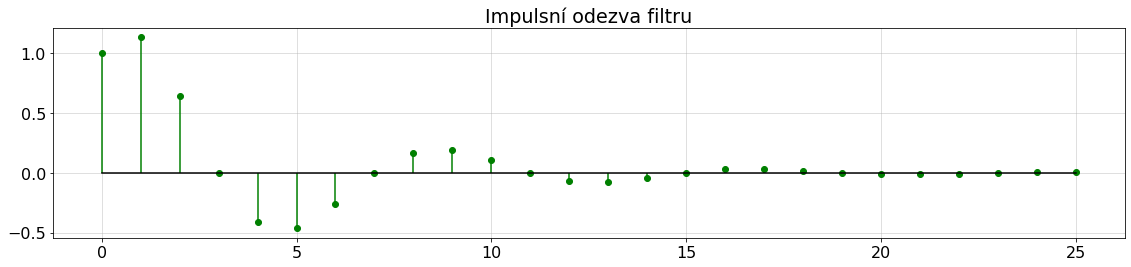

In [8]:
imp = [1, *np.zeros(25)]  # unit impulse
h = lfilter(b, a, imp)

plt.figure()
plt.title('Impulsní odezva filtru')

markerline, stemlines, baseline = plt.stem(h, basefmt="k")
plt.setp(stemlines, 'color', 'g')
plt.setp(markerline, 'color', 'g')
plt.gca().grid(alpha=0.5, linestyle='-')
plt.tight_layout()

### 1.2. Odhad distribuční funkce

Souborové odhady budeme dělat pro určitý čas $n$, v našem případě $n = 50$. Distribuční funkce $F(x,n)$ v zásadě odpovídá na otázku  _jak je pravděpodobné, že hodnota mého signálu pro vzorek $n$ bude menší než nějaká hodnota $x$._ Její hodnotu pro určité $x$ tedy odhadneme tak, že spočítáme v kolika realizacích byla hodnota signálu v čase $n$ menší než $x$ a tento počet podělíme celkovým počtem realizací. Odhad funkce spočítáme pro $x$, které se pohybují mezi minimální a maximální hodnotou našeho signálu v daném čase (pro menší $x$ je distribuční funkce nulová, pro větší $x$ má hodnotu 1). Spojitý průběh funkce aproximujeme pomocí 50 hodnot, pravidelně rozmístěných mezi minimum a maximum.

In [9]:
xmin = np.min(ksi)
xmax = np.max(ksi)

n_aprx = 40  # number of values to aproximate CDF
x = np.linspace(xmin, xmax, n_aprx)

n = 50  # time for which we estimate CDF
Fx = np.zeros(x.shape)
for i in range(n_aprx):
    Fx[i] = np.sum(ksi[:, n] < x[i]) / omega

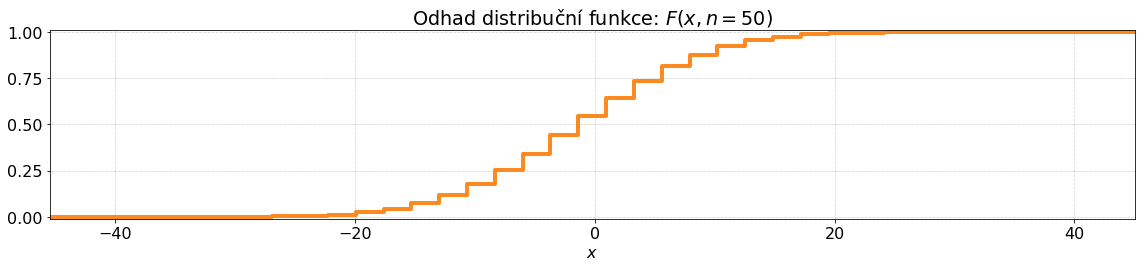

In [10]:
plt.plot(x, Fx, drawstyle='steps', color='#fd8a21', linewidth=4)

plt.title(f'Odhad distribuční funkce: $F(x,n={n})$')
plt.xlabel('$x$')
plt.xlim(xmin, xmax)
plt.ylim(-0.01, 1.01)  
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()

### 1.3. Odhad funkce hustoty rozdělení pravděpodobnosti

Funkce hustoty rozdělení pravděpodobnosti $p(x,n)$ je derivací distribuční funkce $F(x,n)$. Její hodnoty jsou nezáporné a platí, že integrál této funkce přes interval <$a,b$> odpovídá pravděpodobnosti, že hodnota signálu v čase $n$ je v tomto intervalu. Integrál přes celou funkci hustoty rozdělení pravděpodobnosti (od $-\infty$ po $\infty$) by tedy měl být roven 1. 

Souborový odhad pro čas $n=50$ můžeme udělat pomocí histogramu. Budeme opět uvažovat $x$ z intervalu od minima po maximum našeho signálu a opět provedeme aproximaci funkce, rozdělením intervalu do diskrétních úseků. Pro každý úsek spočítáme, v kolika realizacích hodnota signálu v čase $n$ spadá do daného úseku. Tímto získáme histogram hodnot - v Pythonu za nás tento výpočet udělá funkce `numpy.histogram`. Abychom z histogramu dostali funkci $p(x,n)$, musíme jej podělit počtem realizací a velikostí jednoho úseku.

In [11]:
binsize = np.abs(x[1] - x[0])
hist, _ = np.histogram(ksi[:, n], n_aprx)
px = hist / omega / binsize

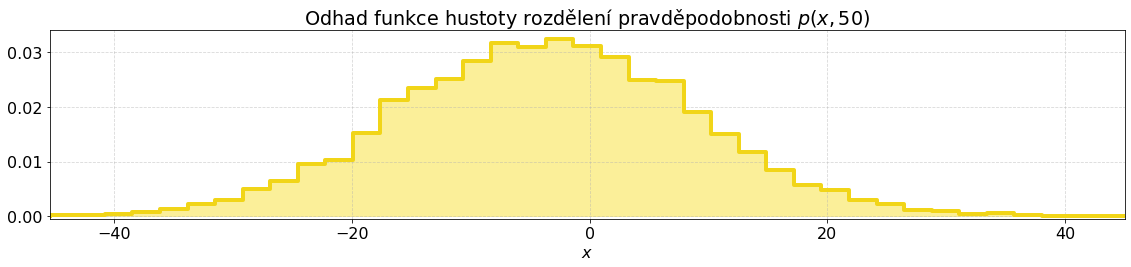

In [12]:
plt.fill_between(x, px, step='pre', color='#fbeb80', alpha=0.8)
plt.plot(x, px, drawstyle='steps', color='#f1d518', linewidth=4)

plt.title(f'Odhad funkce hustoty rozdělení pravděpodobnosti $p(x,{n})$')
plt.xlabel('$x$')
plt.xlim(xmin, xmax)
plt.ylim(-0.0005)
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()

In [13]:
# integruje p(x, n) do 1?
np.sum(px * binsize)

1.0

#### Ukázka CDF, PDF a výpočtu pravděpodobnosti. 

(Nedokončeno - nebylo součástí notebooků poskytnutých studentům).

In [14]:
# from random_5 import *  # TODO...

iplot_cdf_pdf = interactive(
    i_CDF_PDF, 
    ksi=fixed(ksi),
    n_time=(0, 200-1, 10),
    n_aprx=iw_n_aprx,
    a=iw_a,
    b=iw_b ,
    LERP=False,
    continuous_update=False
)
iplot_cdf_pdf.children[-1].layout.height="400px"

In [15]:
iplot_cdf_pdf  # TODO: DISPLAY VALUES

interactive(children=(IntSlider(value=50, description='n_time', max=199, step=10), IntSlider(value=40, descrip…

### 1.4. Odhad střední hodnoty a směrodatné odchylky v čase $n$

Souborový odhad střední hodnoty a směrodatné odchylky spočítáme pro každý čas $n$ a vykreslíme si v závislosti na čase.

In [16]:
mean_n = np.mean(ksi, axis=0)
std_n = np.std(ksi, axis=0)

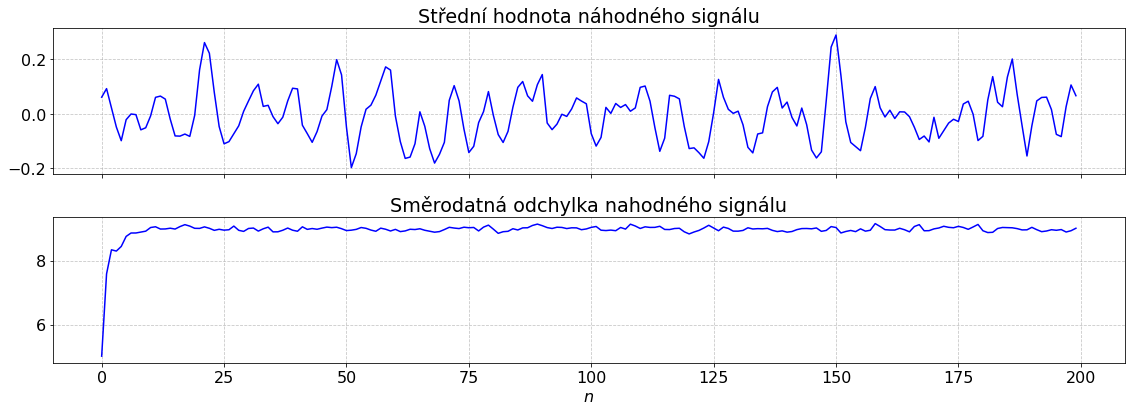

In [17]:
# Generate figure
_, ax = plt.subplots(2, 1, figsize=(16, 6), sharex='col')
for _ax in ax:
    _ax.grid(alpha=0.7, linestyle='--')

ax[0].set_title('Střední hodnota náhodného signálu')
ax[0].plot(mean_n, 'b')

ax[1].set_title('Směrodatná odchylka nahodného signálu')
ax[1].plot(std_n, 'b')
ax[1].set_xlabel('$n$')

plt.tight_layout()

### 1.5. PDF mezi dvěma časy, autokorelační koeficienty

Funkce hustoty rozdělení pravděpodobnosti mezi dvěma časy $p(x_1, x_2, n_1, n_2)$ popisuje vztah hodnot signálu v čase $n_1$ a $n_2$. Integrál této sdružené funkce přes intervaly $x_1 \in <a_1, b_1>$, $x_2 \in <a_2, b_2>$ odpovídá pravděpodobnosti, že hodnota signálu v čase $n_1$ spadá do intervalu $<a_1, b_1>$ a zároveň hodnota $x_2$ spadá do intervalu $<a_2, b_2>$. Odhad této funkce můžeme opět udělat pomocí histogramu - tentokrát 2D histogramu. V Pythonu jej spočítá funkce `numpy.histogram2d`. Výsledný histogram můžeme opět vydělit počtem realizací a velikostí jednoho úseku (tentokrát 2D úseku), abychom získali odhad funkce $p(x_1, x_2, n_1, n_2)$. Druhá možnost je použít parametr `normed=True`, který histogram vynormalizuje za nás.

Autokorelační koeficient $R(n_1,n_2)$ udává míru toho, jak je _signál sám sobě podobný mezi časy $n_1$ a $n_2$._ Vypočteme jej z funkce hustoty rozdělení pravděpodobnosti jako:

$$
R(n_1, n_2) = \int_{-\infty}^{+\infty} \int_{-\infty}^{+\infty} x_1 x_2 p(x_1,x_2, n_1, n_2) dx_1 dx_2.
$$

Prakticky tento integrál v Pythonu můžeme spočítat následovně:
* $p(x_1, x_2, n_1, n_2)$ spočítáme pomocí 2D histogramu, jak naznačeno výše, výsledkem bude matice hodnot
* vytvoříme matici součinů středu jednotlivých úseků $x_1$, $x_2$, nad kterými byl spočítán histogram. Nejjednodušeji toto můžeme udělat pomocí outer produktu vektorů těchto středů
* tyto dvě matice prvek po prvku vynásobíme
* samotný integrál pak získáme jako součet hodnot v matici vynásobený obsahem jednotlivých 2D úseků

V interaktivní ukázce si zobrazte výstup například pro hodnoty: $n_1=50$ a $n_2$ od $50$ do $65$.

In [18]:
def acorr_coef(ksi, n_bins=40, n1=50, n2=51):
    """ Vypočte hodnotu autokorelačního koeficientu pro časy n1 a n2. """
    px1x2, x1_edges, x2_edges = np.histogram2d(ksi[:, n1], ksi[:, n2], 
                                               n_bins, normed=True)
    # x1 * x2
    bin_centers_x1 = x1_edges[:-1] + (x1_edges[1:] - x1_edges[:-1]) / 2
    bin_centers_x2 = x2_edges[:-1] + (x2_edges[1:] - x2_edges[:-1]) / 2
    x1x2 = np.outer(bin_centers_x1, bin_centers_x2)
    
    binsize = np.abs(x1_edges[0] - x1_edges[1]) * np.abs(x2_edges[0] - x2_edges[1])
    
    # auto-correlation coefficient
    R = np.sum(x1x2 * px1x2 * binsize)
    return R

acorr_coef(ksi, n_bins=40, n1=50, n2=51)

55.169201315599764

In [19]:
def integrate_JPDF(ksi, n_bins=40, n1=50, n2=51):
    """ Integrates Joint Probability Density Function. """
    px1x2, x1_edges, x2_edges = np.histogram2d(ksi[:, n1], ksi[:, n2], n_bins, normed=True)
    binsize = np.abs(x1_edges[0] - x1_edges[1]) * np.abs(x2_edges[0] - x2_edges[1])
    
    return np.sum(px1x2 * binsize)  # integral p(x1, x2, n1, n2) ~= 1

integrate_JPDF(ksi, n_bins=40, n1=50, n2=51)

0.9999999999999974

In [20]:
from random_5 import ipy_JPDF        
        
n_ranges = (0, 199, 1)  # (30, 70, 1)  

iplot_accoef = interactive(
    ipy_JPDF, 
    ksi=fixed(ksi),
    n1=n_ranges,
    n2=n_ranges,
    n_bins=(5, 80, 5),
    continuous_update=False
)
iplot_accoef.children[-1].layout.height="800px"

In [21]:
iplot_accoef  # displays counts instead of PDFs values

interactive(children=(IntSlider(value=50, description='n1', max=199), IntSlider(value=51, description='n2', ma…

## 2 Časové odhady

### 2.1. Generování náhodného procesu

Budeme používat stejný náhodný proces jako v minulé části projektu, tedy
gaussovský šum prošlý filtrem

$$
H(z) = \frac{1}{1 - 1.1314 z^{-1} + 0.6400z^{-2}}\ ,
$$

ale vygenerujeme jen jednu realizaci, která bude dostatečně dlouhá: 10000 vzorků.

In [22]:
# one realization!
N = 10000  # sample count

# Normal distribution parameters
mean = 0
std = 5

# Filter parameters
b = [1, 0, 0]
a = [1, -1.1314, 0.6400]

# Generate random process
ORIG = np.random.normal(mean, std, N)
KSI = lfilter(b, a, ORIG)

KSI.shape

(10000,)

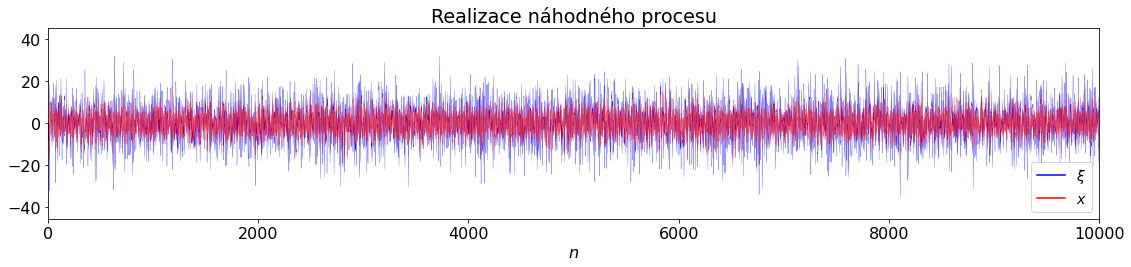

In [23]:
plt.figure()
plt.gca().set_title(f'Realizace náhodného procesu')
plt.gca().set_xlabel('$n$')
plt.plot(KSI, 'b', linewidth=0.2, label="$\\\x78i$")
plt.plot(ORIG, 'r', linewidth=0.3, alpha=0.6, label='$x$')

plt.xlim(0, omega)
plt.ylim(ksi.min(), ksi.max())

b_line = mlines.Line2D([], [], color='blue', label="$\\\x78i$")
r_line = mlines.Line2D([], [], color='red', label='$x$')
plt.legend(handles=[b_line, r_line], fontsize=14)
plt.tight_layout()

### 2.2. Odhad distribuční funkce a funkce hustoty rozdělení pravděpodobnosti

Opět spočítáme analogicky k souborovým odhadům, ale místo toho, abychom dělali odhad pro daný čas, přes všechny realizace, budeme odhadovat přes všechny časy v rámci jedné realizace.

In [24]:
xmin = np.min(KSI)
xmax = np.max(KSI)

n_aprx = 50  # pocet hodnot, kterymi aproximujeme dist fci
x = np.linspace(xmin, xmax, n_aprx)

Fx = np.zeros(x.shape)
for i in range(n_aprx):
    Fx[i] = np.sum(KSI < x[i]) / N

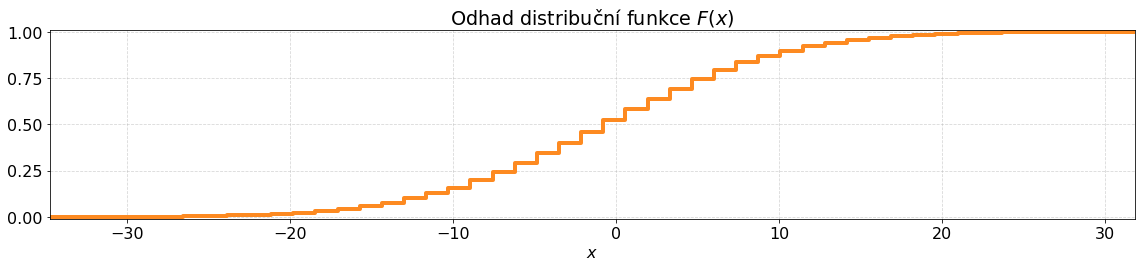

In [25]:
plt.figure()
plt.plot(x, Fx, drawstyle='steps', color='#fd8a21', linewidth=4)

plt.gca().set_title(f'Odhad distribuční funkce $F(x)$')
plt.gca().set_xlabel('$x$')
plt.gca().set_xlim(xmin, xmax), plt.gca().set_ylim(-0.01, 1.01)
plt.gca().grid(alpha=0.5, linestyle='--')
plt.tight_layout()

In [26]:
binsize = np.abs(x[1] - x[0])
hist, _ = np.histogram(KSI, n_aprx)
px = hist / N / binsize

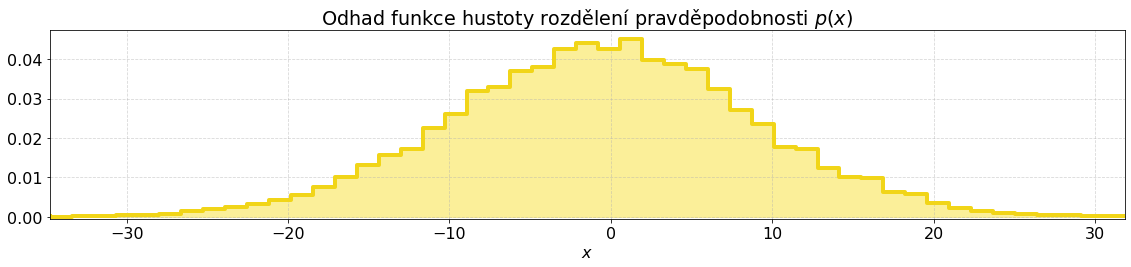

In [27]:
plt.figure()
plt.fill_between(x, px, step='pre', color='#fbeb80', alpha=0.8)
plt.plot(x, px, drawstyle='steps', color='#f1d518', linewidth=4)
# plt.plot(x, px, color='r', linewidth=0.5, alpha=0.9, linestyle='-')

plt.gca().set_title(f'Odhad funkce hustoty rozdělení pravděpodobnosti $p(x)$')
plt.gca().set_xlabel('$x$')
plt.gca().set_xlim(xmin, xmax), plt.gca().set_ylim(-0.0005)  # -40, 40
plt.gca().grid(alpha=0.5, linestyle='--')
plt.tight_layout()

In [28]:
np.sum(px * binsize)  # Integral of p(x) should equal to 1

1.0

### 2.3. Odhad střední hodnoty a směrodatné odchylky

Narozdíl od souborového odhadu, kde jsme odhady počítali průměrováním přes všechny realizace, u časového odhadu budeme průměrovat přes čas v rámci jedné realizace.

In [29]:
(np.mean(KSI), np.std(KSI))

(0.031020274292958117, 9.130316780918465)

### 2.4. Odhad autokorelačních koeficientů

Zatímco u souborových odhadů jsme počítali autokorelační koeficienty mezi dvěma konkrétními časy $n_1$, $n_2$, u časového odhadu budeme počítat autokorelační koeficient mezi všemi dvojicemi časů, které jsou vzdálené $k$. Autokorelační koeficient tu tedy udává míru toho _jak si je signál podobný v čase n a čase n+k_. Odhad bychom opět mohli udělat ze sdružené funkce hustoty rozdělení pravděpodobnosti $p(x_1, x_2, k)$ - časový odhad této funkce bychom udělali analogicky k souborovému odhadu, ale místo hodnot signálu v časech $n_1$ a $n_2$ přes všechny realizace bychom použili hodnoty signálu v časech $n$ a $n+k$ přes všechny časy $n$.

Autokorelační koeficienty můžeme ale odhadnout i přímo, bez funkce hustoty rozdělení pravděpodobnosti, násobením hodnot signálu v čase $n$ a $n+k$ a průměrem přes všechny časy $n$. Rozlišujeme tzv. vychýlený odhad $R_v(k)$ a nevychýlený odhad $R_{nv}(k)$ podle toho, zda dělíme celkovým počtem vzorků nebo jen počtem vzorků, kde se $x[n]$ a $x[n+k]$ překrývají:

$$
\hat{R}_v(k) = \frac{1}{N} \sum_{n=0}^{N-1} x[n]x[n+k],~~~~~~\hat{R}_{nv}(k) = \frac{1}{N-|k|} \sum_{n=0}^{N-1} x[n]x[n+k],
$$

V Pythonu můžeme použít například funkci `numpy.correlate` a výsledek vhodně normalizovat.

In [30]:
k = np.arange(-N + 1, N)

Rv = np.correlate(KSI, KSI, 'full') / N
Rnv = np.correlate(KSI, KSI, 'full') / (N - np.abs(k))

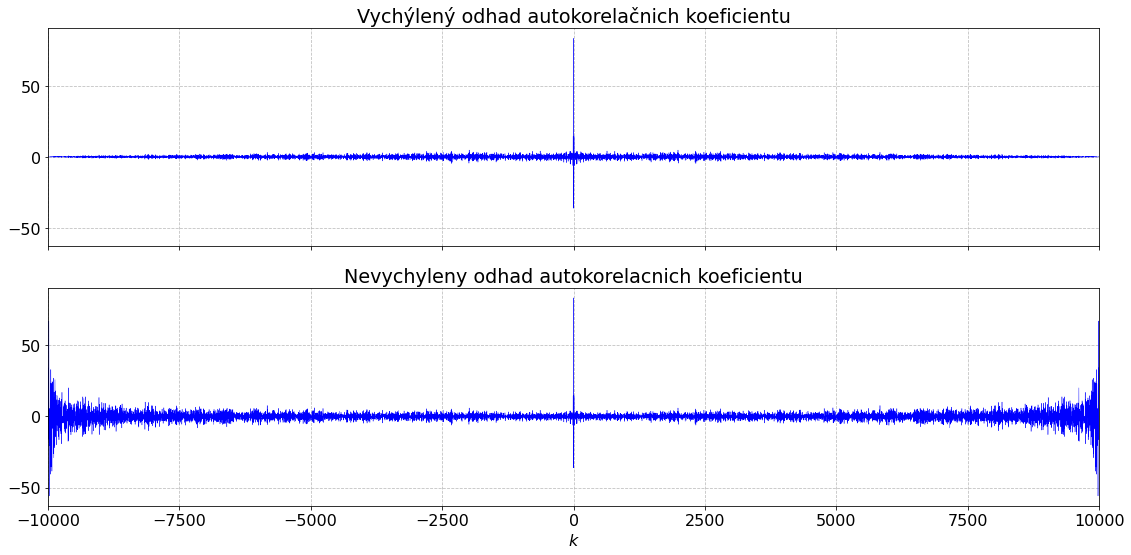

In [31]:
_, ax = plt.subplots(2, 1, figsize=(16, 8), sharex='col', sharey='col')

ax[0].set_title('Vychýlený odhad autokorelačnich koeficientu')
ax[0].plot(k, Rv, 'b', linewidth=0.4)

ax[1].set_title('Nevychyleny odhad autokorelacnich koeficientu')
ax[1].plot(k, Rnv, 'b', linewidth=0.4)

ax[1].set_xlabel('$k$')

for _ax in ax:
    _ax.grid(alpha=0.8, linestyle='--')
    _ax.set_xlim(-1E4, 1E4)
plt.tight_layout()

## 3 Odhady spektra

Na závěr se podíváme na to, jak odhadnout spektrální hustotu výkonu (PSD) náhodného signálu a jak se PSD změní po průchodu signálu filtrem.

### 3.1. Spektrální hustota výkonu - power spectral density (PSD)

Budeme ji odhadovat pomocí DFT z celé realizace nebo průměrováním přes několik segmentů  (vztahy viz. přednáška, slajdy 14 a 15). Průměrování by mělo vést k hladšímu odhadu.

In [32]:
# odhad z cele realizace
G_dft = 1/N * np.abs(np.fft.fft(KSI))**2
w_dft = np.linspace(0, 2*np.pi, G_dft.size)

In [33]:
# odhad prumerovanim pres nekolik segmentu
n_per_seg = 100
KSI_resh = np.reshape(KSI, (-1, n_per_seg))
G_per_seg = np.abs(np.fft.fft(KSI_resh))**2 / n_per_seg
G_prum = np.mean(G_per_seg, axis=0)
w_prum = np.linspace(0, 2*np.pi, G_prum.size)

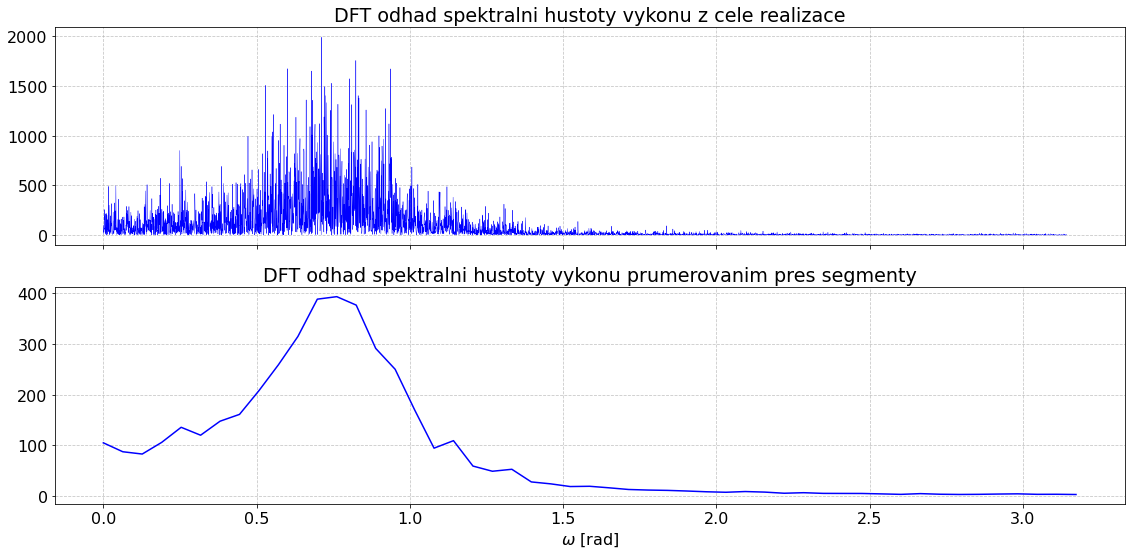

In [34]:
_, ax = plt.subplots(2, 1, figsize=(16, 8), sharex='col')
for ax1 in ax:
    ax1.grid(alpha=0.7, linestyle='--')

ax[0].set_title('DFT odhad spektralni hustoty vykonu z cele realizace')
ax[0].plot(w_dft[:w_dft.size//2+1], G_dft[:G_dft.size//2+1], 'b', linewidth=0.4)

ax[1].set_title('DFT odhad spektralni hustoty vykonu prumerovanim pres segmenty')
ax[1].set_xlabel('$\omega$ [rad]')
ax[1].plot(w_prum[:w_prum.size//2+1], G_prum[:G_prum.size//2+1], 'b')

plt.tight_layout()

### 3.2. Průchod náhodného signálu lineárním systémem

Necháme náš náhodný signál projít filtrem s přenosovou funkcí:

$$
H(z) = {1    -1.1314 z^{-1} +    0.6400z^{-2}}
$$

(všimněte si, že to je inverzní  filtr k tomu, který jsme použili na začátku). Spektrální hustota výkonu  na výstupu by měla být: 

$$
G_y(e^{j\omega}) = |H(e^{j\omega})|^2  G_x(e^{j\omega}),
$$

což se pokusíme ověřit.

In [35]:
# Filter parameters (inverse to our previous filter)
b_i = [1, -1.1314, 0.64]
a_i = [1, 0, 0]

# Frequency response
w, H = freqz(b_i, a_i, 51)
H2 = np.abs(H)**2  

# Apply filter
y = lfilter(b_i, a_i, KSI)

In [36]:
# spektralni hustota vykonu vystupniho signalu
# odhad prumerovanim pres nekolik segmentu
n_per_seg = 100

y_resh = np.reshape(y, (-1, n_per_seg))
Gy_per_seg = np.abs(np.fft.fft(y_resh))**2 / n_per_seg
Gy_prum = np.mean(Gy_per_seg, axis=0)

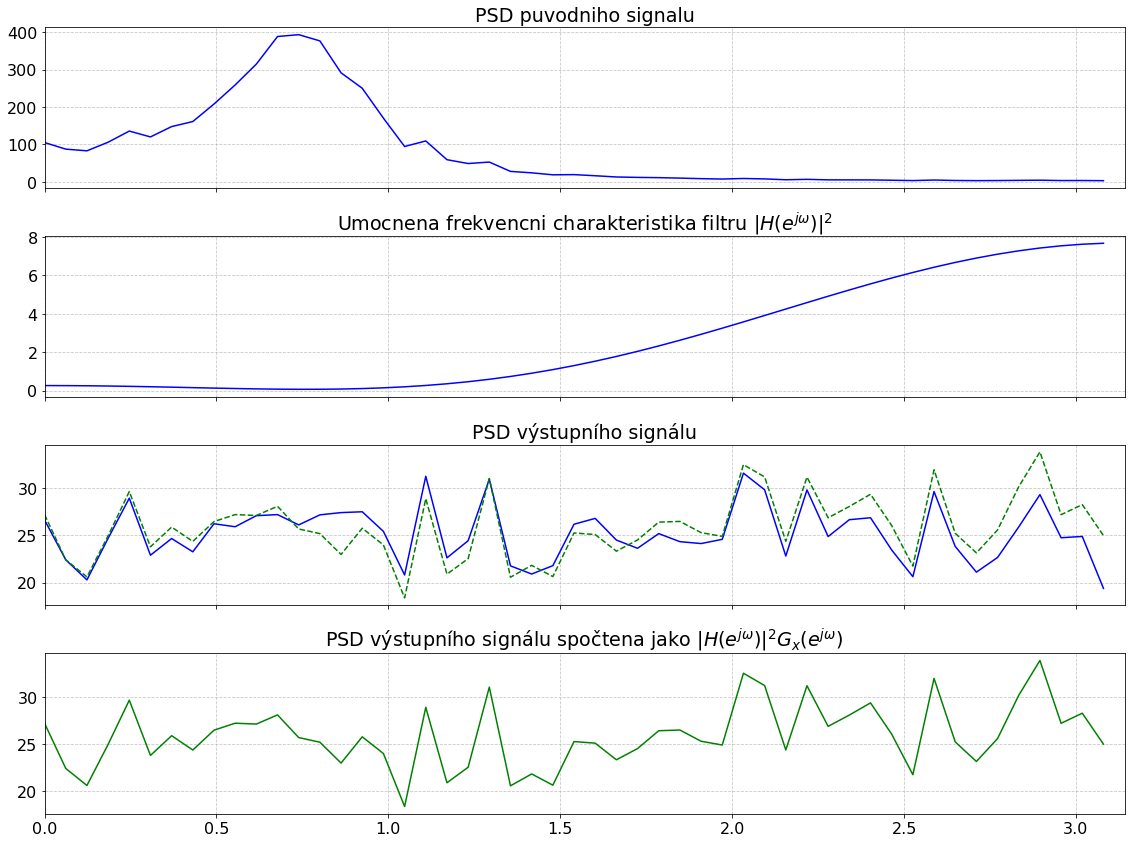

In [37]:
_, ax = plt.subplots(4, 1, figsize=(16, 12), sharex='col')

Gy_half = Gy_prum.size//2 + 1

ax[0].set_title('PSD puvodniho signalu')
ax[0].plot(w, G_prum[:Gy_half], 'b')

ax[1].set_title('Umocnena frekvencni charakteristika filtru $|H(e^{j\omega})|^2$')
ax[1].plot(w, H2, 'b')

ax[2].set_title('PSD výstupního signálu')
ax[2].plot(w, Gy_prum[:Gy_half],'b')
ax[2].plot(w, G_prum[:Gy_half] * H2, 'g--')

ax[3].set_title('PSD výstupního signálu spočtena jako $|H(e^{j\omega})|^2 G_x(e^{j\omega})$')
ax[3].plot(w, G_prum[:Gy_half] * H2, 'g')
ax[3].get_shared_y_axes().join(ax[2], ax[3])

for _ax in ax:
    _ax.grid(alpha=0.7, linestyle='--')
    _ax.set_xlim(0, np.pi)
plt.tight_layout()

# // ----- - ----- //